<a href="https://colab.research.google.com/github/TatyanaPythonista/handwritten__digit_recognition_by_pytorch/blob/main/handwritten__digit_recognition_by_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Импортирую датасет

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
x_train = MNIST_train.data
y_train = MNIST_train.targets
x_test = MNIST_test.data
y_test = MNIST_test.targets

In [4]:
x_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
x_train = x_train.float()
x_test = x_test.float()

In [6]:
x_train.shape, x_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

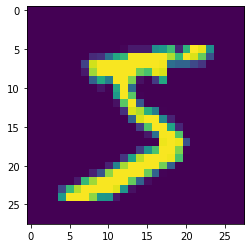

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0, :, :])
plt.show()
print(y_train[0])

'Растягиваю' картинку в одну строчку

In [10]:
x_train = x_train.reshape([-1, 28*28])
x_test = x_test.reshape([-1, 28*28])

In [11]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super().__init__()
    self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
    self.ac1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    return x

mnist_net = MNISTNet(100)

In [12]:
torch.cuda.is_available()

True

In [13]:
!nvidia-smi

Wed Sep 22 02:08:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)

In [18]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

x_test = x_test.to(device)
y_test = y_test.to(device)

for each in range(10000):
  order = np.random.permutation(len(x_train))

  for start_index in range(0, len(x_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]
    
    x_batch = x_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)

    preds = mnist_net.forward(x_batch)

    loss_value = loss(preds, y_batch)
    loss_value.backward()

    optimizer.step()

  test_preds = mnist_net.forward(x_test)

  test_loss_history.append(loss(test_preds, y_test))

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()

  test_accuracy_history.append(accuracy)

  print(accuracy)


tensor(0.9492, device='cuda:0')
tensor(0.9539, device='cuda:0')
tensor(0.9535, device='cuda:0')
tensor(0.9587, device='cuda:0')
tensor(0.9579, device='cuda:0')
tensor(0.9594, device='cuda:0')
tensor(0.9576, device='cuda:0')
tensor(0.9565, device='cuda:0')
tensor(0.9587, device='cuda:0')
tensor(0.9567, device='cuda:0')
tensor(0.9574, device='cuda:0')
tensor(0.9562, device='cuda:0')
tensor(0.9563, device='cuda:0')
tensor(0.9615, device='cuda:0')
tensor(0.9590, device='cuda:0')
tensor(0.9578, device='cuda:0')
tensor(0.9611, device='cuda:0')
tensor(0.9585, device='cuda:0')
tensor(0.9570, device='cuda:0')
tensor(0.9615, device='cuda:0')
tensor(0.9625, device='cuda:0')
tensor(0.9612, device='cuda:0')
tensor(0.9615, device='cuda:0')
tensor(0.9570, device='cuda:0')
tensor(0.9611, device='cuda:0')


KeyboardInterrupt: ignored

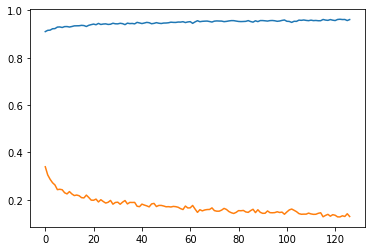

In [19]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history)